<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/U_net_sansgenerateur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [1]:
!pip install nussl

In [2]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-5hw_z78s
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-5hw_z78s


In [3]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Montage du drive

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Récupération des données

In [4]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

# Paramètres du modèle

In [5]:
#  Préprocess

n_train               = 100        # nombre de chansons en train maxi=len(musdb_train)=100
augmentation_factor   = 2         # paramètres de data augmentation

freq                  = 4096      # fréquence de reéchantillonage
window_length         = 511       # taille fenêtre FFT
hop_length            = 384       # recouvrement FFT
patch_size            = 64        # taille du patch temporel pour  CNN   

nfreq                 = 256       # nombre de bins dans l'espace fréquentiel= (window_length+1)/2        


#  CNN
batch_size            = 32        # taille des batch 



# Définition de fonctions utiles

Une fonction pour le préprocessing des données :
- rééchantillonage,
- passage en mono,
- STFT et séparation magnitude et phase.

In [6]:
def preprocess(music_data,
               freq=freq,
               window_length=window_length,
               hop_length=hop_length,
               normalize=True):
  
  # Spectro voix et mix
  voice = music_data['sources']["vocals"]
  mix = music_data['mix']

  # Resampling 
  if freq is not None:
    voice.resample(freq,res_type='kaiser_fast')
    mix.resample(freq,res_type='kaiser_fast')

  # Passage en mono
  voice.to_mono()
  mix.to_mono()

  # fft mix et voix (magnitude normalisée et phase)
  stftvoice = voice.stft(window_length=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = mix.stft(window_length=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  if normalize:
    norm = magmix.max()
    magmix /= norm
    magvoice /= norm
    return magmix, magvoice, phasemix, norm

  return magmix, magvoice, phasemix

# Spectrogrammes et création du dataset

Création du dataset a priori (pas de générateur). Calcul des spectres et concaténation. On peut ensuite faire une data augmentation en prenant aléatoirement dedans.

In [7]:
# calcul et concaténation des spectres
k=0
for npiste in range(n_train):
  magmix, magvoice, *_ = preprocess(musdb_train[npiste])

# concatenation
  k=k+1
  print("processing:",k)

  if (k==1):
    X_mix_full   =magmix.reshape(nfreq,-1)
    X_voice_full =magvoice.reshape(nfreq,-1)
  else:
    X_mix_full  =np.append(X_mix_full,magmix.reshape(nfreq,-1),axis=1)
    X_voice_full=np.append(X_voice_full,magvoice.reshape(nfreq,-1),axis=1)
 
 

processing: 1
processing: 2
processing: 3
processing: 4
processing: 5
processing: 6
processing: 7
processing: 8
processing: 9
processing: 10
processing: 11
processing: 12
processing: 13
processing: 14
processing: 15
processing: 16
processing: 17
processing: 18
processing: 19
processing: 20
processing: 21
processing: 22
processing: 23
processing: 24
processing: 25
processing: 26
processing: 27
processing: 28
processing: 29
processing: 30
processing: 31
processing: 32
processing: 33
processing: 34
processing: 35
processing: 36
processing: 37
processing: 38
processing: 39
processing: 40
processing: 41
processing: 42
processing: 43
processing: 44
processing: 45
processing: 46
processing: 47
processing: 48
processing: 49
processing: 50
processing: 51
processing: 52
processing: 53
processing: 54
processing: 55
processing: 56
processing: 57
processing: 58
processing: 59
processing: 60
processing: 61
processing: 62
processing: 63
processing: 64
processing: 65
processing: 66
processing: 67
proc

In [8]:
#data  augmentation par découpage aléatoire
X_mix_fullT = X_mix_full.T
X_voice_fullT = X_voice_full.T
nimages0=X_mix_fullT.shape[0]//patch_size   # nombre total d'images disjointes
nimages=nimages0 * augmentation_factor     # facteur de sur-échantillonnage

Xm, Xv,  = [], [] 
starts = np.random.randint(0, X_mix_fullT.shape[0]-patch_size, nimages)
for start in starts:
  end = start + patch_size
  Xm.append(X_mix_fullT[start:end,:])
  Xv.append(X_voice_fullT[start:end,:])

print('Data set: ',k, 'songs')
print('Images0 : ',nimages0)
print('Data set: ',nimages, 'training images with size',nfreq,'x',patch_size)
 

X_mix=np.array(Xm)
X_voice=np.array(Xv)
             
#X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
#X_voice=np.expand_dims(X_voice,axis=3)



Data set:  100 songs
Images0 :  3813
Data set:  7626 training images with size 256 x 64


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [21]:
# v2 : UNET avec conv6  : 2,3  Millions param
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Flatten, Dense, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation
from tensorflow.keras import callbacks

# Création de la structure

nframes=patch_size
inputs=Input(shape =(nframes,nfreq,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (3,3), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (3,3), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (3,3), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = Dropout(0.5)(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)

mask     = Activation('sigmoid')(deconv12)

output1 = tf.multiply(inputs,mask)



unet = Model(inputs=inputs, outputs=output1)
unet.summary()

unet.compile(loss='mean_absolute_error',   
              optimizer='adam')            

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=20,
                                         factor=0.7,
                                         verbose=2,
                                         mode='min')

train_history=unet.fit(x=X_mix,y=X_voice,
                       validation_split=0.1,
                       epochs=50,
                       batch_size=batch_size,
                       callbacks = [early_stopping, lr_plateau])



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 128, 16)  416         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_33 (BatchN  (None, 32, 128, 16)  64         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                            

Plot des pertes

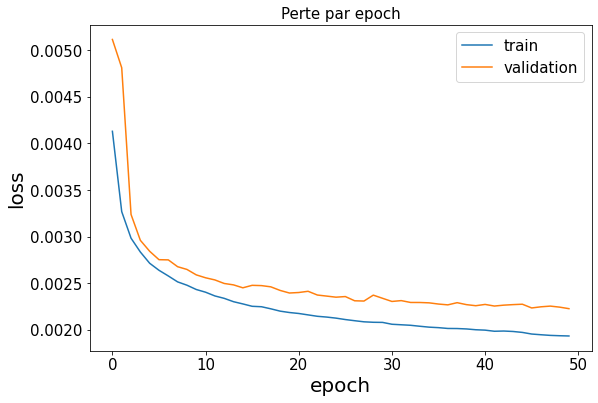

In [22]:
plt.figure(figsize=(9,6))
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Perte par epoch' ,fontsize=15)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validation'], loc='best',fontsize=15)
plt.show();


# Sauvegarde / Chargement d'un réseau existant

In [23]:
import secrets
from datetime import datetime

name = "model"
date = datetime.today().strftime('%Y%m%d')
rand_key = secrets.token_hex(8)
full_name = f"{name}_{date}_{rand_key}"

unet.save(os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet",full_name))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet Datascientest/UNet/model_20220201_c179927b2c137453/assets


In [27]:
from tensorflow.keras.models import load_model

model_path = os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet","model_20220201_100x2_2.3M")
print(model_path)
unet = load_model(model_path)

/content/drive/MyDrive/Projet Datascientest/UNet/model_20220201_100x2_2.3M


# Ecoute

In [24]:
# fonction de reshape des données
def reshape(X_mix, X_voice, patch_size=patch_size):
  # transposition pour mettre le temps en première composante  
  X_mix = X_mix.T
  X_voice = X_voice.T

  # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
  nimages = X_mix.shape[0]//patch_size   # nombre total d'images
  newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

  X_mix_resized = X_mix[:newsize]
  X_voice_resized = X_voice[:newsize]

  X_mix = np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
  X_voice = np.array(np.split(X_voice_resized, nimages, axis=0))

  X_mix = np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
  X_voice = np.expand_dims(X_voice,axis=3)

  return X_mix, X_voice


AudioSignal (unlabeled): 200.342 sec @ Al James - Schoolboy Facination, 4096 Hz, 1 ch.


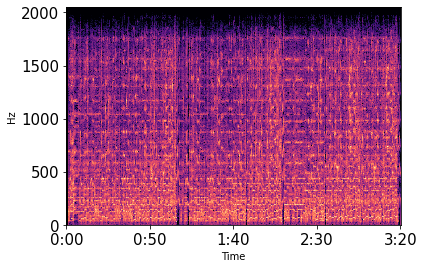

AudioSignal (unlabeled): 200.342 sec @ musdb/Al James - Schoolboy Facination_vocals.wav, 4096 Hz, 1 ch.


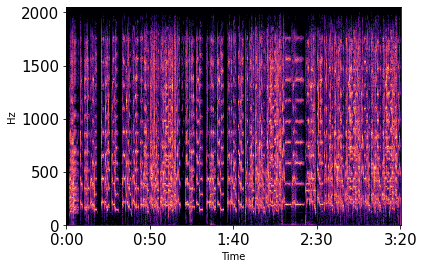

AudioSignal (unlabeled): 197.906 sec @ path unknown, 4096 Hz, 1 ch.


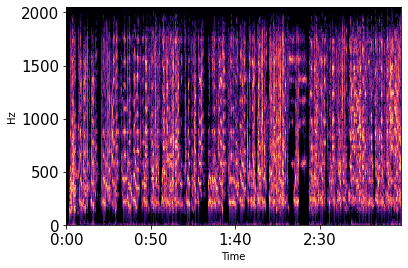

In [17]:
# écoute d'une musique au choix
data = musdb_test[1]



magmix, magvoice, phase, norm = preprocess(data)
Xmix, Xvoice = reshape(magmix[:,:,0], magvoice[:,:,0], patch_size)

print(data["mix"])
data["mix"].embed_audio()
nussl.utils.visualize_spectrogram(data["mix"])
plt.show()

print(data["sources"]["vocals"])
data["sources"]["vocals"].embed_audio()
nussl.utils.visualize_spectrogram(data["sources"]["vocals"],)
plt.show()

Xvoice_pred =unet.predict(Xmix)
magmix_pred = Xvoice_pred.reshape(-1,nfreq,1).transpose(1,0,2)
end = magmix_pred.shape[1]
audio_pred = nussl.AudioSignal(stft=magmix_pred*norm*phase[:,:end],sample_rate=freq)
audio_pred.istft(window_length=window_length,hop_length=hop_length)
print(audio_pred)
audio_pred.embed_audio()
nussl.utils.visualize_spectrogram(audio_pred)
plt.show()



# Evaluations (métriques)

In [ ]:
data = musdb_test[0]

def preprocess_mix(mix,
                   freq=freq,
                   window_length=window_length,
                   hop_length=hop_length,
                   normalize=True):

  # Resampling à 16 kHz (pour data plus light)
  if freq is not None:
    mix.resample(freq,res_type='kaiser_fast')

  # Passage en mono
  mix.to_mono()

  # fft mix et voix (magnitude normalisée et phase)
  stftmix = mix.stft(window_length=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  if normalize:
    norm = magmix.max()
    magmix /= norm
    return magmix, phasemix, norm

  return magmix, phasemix


def reshape_mix(X_mix, patch_size=128, extend=False):
  # transposition pour mettre le temps en première composante  
  X_mix = X_mix.T

  if extend:
    # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
    nimages = int(np.ceil(X_mix.shape[0]/patch_size))   # nombre total d'images
    newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

    X_mix_resized = np.concatenate((X_mix,np.zeros((newsize-X_mix.shape[0],X_mix.shape[1]))))
  else:
    # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
    nimages = X_mix.shape[0]//patch_size   # nombre total d'images
    newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

    X_mix_resized = X_mix[:newsize]

  X_mix = np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 

  X_mix = np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 

  return X_mix

class UNetModel:

  def __init__(self,mix,model):
    self.mix = mix
    self.model = model
  def __call__(self):
    magmix, phase, norm = preprocess_mix(self.mix)
    X_mix = reshape_mix(magmix[:,:,0], patch_size, extend=True)
    X_voice_pred = self.model.predict(X_mix)
    magmix_pred = X_voice_pred.reshape(-1,nfreq,1).transpose(1,0,2)
    end = magmix.shape[1]
    audio_pred = nussl.AudioSignal(stft=magmix_pred[:,:end]*norm*phase,sample_rate=freq)
    audio_pred.istft(window_length=window_length,hop_length=hop_length)
    audio_pred.truncate_seconds(self.mix.signal_duration)
    return [audio_pred*2,audio_pred]

unet_model = UNetModel(data["mix"],unet)
audio_pred = unet_model()[1]


from voicesep.models import evaluate_dict_models
from glob import glob
truth = [data["sources"]['drums+bass+other'], data["sources"]['vocals']]
truth[0].resample(freq,res_type='kaiser_fast')
truth[1].resample(freq,res_type='kaiser_fast')
truth[0].to_mono()
truth[1].to_mono()
print(truth[0])
nussl.utils.visualize_spectrogram(truth[0], y_axis='mel')
plt.show()
print(truth[1])
nussl.utils.visualize_spectrogram(truth[1], y_axis='mel')
plt.show()
models = glob(os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet","model_202202*"))
unets=[]
for m in models:
  try:
    print(m)
    if "stany" in m:
      print("pass")
      continue
    unets.append(load_model(m))
  except:
    print("error")
  print(unets)
sep_class_dict = {
                  f"UNet{i}": UNetModel(data["mix"],u) for i,u in enumerate(unets)
                 }

scores = evaluate_dict_models(sep_class_dict, truth)